In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%load_ext tensorboard

In [4]:
!unzip /content/gdrive/MyDrive/Dataset/VOC_2007/VOC2007.zip > /dev/null

In [ ]:
!unzip /content/gdrive/MyDrive/Dataset/Shape/Shape.zip > /dev/null

In [2]:
import argparse
import xml.etree.ElementTree as ET
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.utils import Sequence
import math
import json
import numpy as np
from keras.layers import *
from keras.regularizers import l2
import keras.backend as K
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
import configparser
import io
import datetime
from collections import defaultdict

# **Convert Darknet Model to Keras**

In [31]:
"""
Reads Darknet config and weights and creates Keras models with TF backend.
Currently only supports layers in Yolov1-tiny config.
"""

# import argparse




# parser = argparse.ArgumentParser(description='Darknet Yolov1-tiny To Keras Converter.')
# parser.add_argument('config_path', help='Path to Darknet cfg file.')
# parser.add_argument('weights_path', help='Path to Darknet weights file.')
# parser.add_argument('output_path', help='Path to output Keras models file.')


def unique_config_sections(config_file):
    """Convert all config sections to have unique names.

    Adds unique suffixes to config sections for compability with configparser.
    """
    section_counters = defaultdict(int)
    output_stream = io.StringIO()
    with open(config_file) as fin:
        for line in fin:
            if line.startswith('['):
                section = line.strip().strip('[]')
                _section = section + '_' + str(section_counters[section])
                section_counters[section] += 1
                line = line.replace(section, _section)
            output_stream.write(line)
    output_stream.seek(0)
    return output_stream


config_path = '/content/gdrive/MyDrive/Dataset/VOC_2007/yolov1-tiny.cfg'
weights_path = '/content/gdrive/MyDrive/Dataset/VOC_2007/tiny-yolov1.weights'
output_path = '/content/tiny-yolov1.hdf5'
assert config_path.endswith('.cfg'), \
    '{} is not a .cfg file'.format(config_path)
assert weights_path.endswith('.weights'), \
    '{} is not a .weights file'.format(weights_path)
assert output_path.endswith('.hdf5'), \
    'output path {} is not a .hdf5 file'.format(output_path)

# Load weights and config.
print('Loading weights.')
weights_file = open(weights_path, 'rb')
weights_header = np.ndarray(
    shape=(4, ), dtype='int32', buffer=weights_file.read(16))
print('Weights Header: ', weights_header)

print('Parsing Darknet config.')
unique_config_file = unique_config_sections(config_path)
cfg_parser = configparser.ConfigParser()
cfg_parser.read_file(unique_config_file)

print('Creating Keras models.')

try:
    image_height = int(cfg_parser['crop_0']['crop_height'])
    image_width = int(cfg_parser['crop_0']['crop_width'])
except KeyError:
    image_height = int(cfg_parser['net_0']['height'])
    image_width = int(cfg_parser['net_0']['width'])

prev_layer = Input(shape=(image_height, image_width, 3))
all_layers = [prev_layer]

weight_decay = float(cfg_parser['net_0']['decay']
                      ) if 'net_0' in cfg_parser.sections() else 5e-4
count = 0
fc_flag = False
for section in cfg_parser.sections():
    print('Parsing section {}'.format(section))
    if section.startswith('convolutional'):
        filters = int(cfg_parser[section]['filters'])
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        pad = int(cfg_parser[section]['pad'])
        activation = cfg_parser[section]['activation']
        batch_normalize = 'batch_normalize' in cfg_parser[section]

        # padding='same' is equivalent to Darknet pad=1
        padding = 'same' if pad == 1 else 'valid'

        # Setting weights.
        # Darknet serializes convolutional weights as:
        # [bias/beta, [gamma, mean, variance], conv_weights]
        prev_layer_shape = K.int_shape(prev_layer)

        # TODO: This assumes channel last dim_ordering.
        weights_shape = (size, size, prev_layer_shape[-1], filters)
        darknet_w_shape = (filters, weights_shape[2], size, size)
        weights_size = np.product(weights_shape)

        print('conv2d', 'bn'
              if batch_normalize else '  ', activation, weights_shape)

        conv_bias = np.ndarray(
            shape=(filters, ),
            dtype='float32',
            buffer=weights_file.read(filters * 4))
        count += filters

        bn_weight_list = []
        if batch_normalize:
            bn_weights = np.ndarray(
                shape=(3, filters),
                dtype='float32',
                buffer=weights_file.read(filters * 12))
            count += 3 * filters

            # TODO: Keras BatchNormalization mistakenly refers to var
            # as std.
            bn_weight_list = [
                bn_weights[0],  # scale gamma
                conv_bias,  # shift beta
                bn_weights[1],  # running mean
                bn_weights[2]  # running var
            ]

        conv_weights = np.ndarray(
            shape=darknet_w_shape,
            dtype='float32',
            buffer=weights_file.read(weights_size * 4))
        count += weights_size

        # DarkNet conv_weights are serialized Caffe-style:
        # (out_dim, in_dim, height, width)
        # We would like to set these to Tensorflow order:
        # (height, width, in_dim, out_dim)
        # TODO: Add check for Theano dim ordering.
        conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
        conv_weights = [conv_weights] if batch_normalize \
            else [conv_weights, conv_bias]

        # Handle activation.
        act_fn = None
        if activation == 'leaky':
            pass  # Add advanced activation later.
        elif activation == 'relu':
            pass
        elif activation != 'linear':
            raise ValueError(
                'Unknown activation function `{}` in section {}'.format(
                    activation, section))

        # Create Conv2D layer
        conv_layer = Conv2D(
            filters, (size, size),
            strides=(stride, stride),
            kernel_regularizer=l2(weight_decay),
            use_bias=not batch_normalize,
            weights=conv_weights,
            activation=act_fn,
            padding=padding,
            name=format(section))(prev_layer)

        if batch_normalize:
            conv_layer = BatchNormalization(
                weights=bn_weight_list,
                name='bn' + format(section))(conv_layer)

        prev_layer = conv_layer

        if activation == 'linear':
            all_layers.append(prev_layer)
        elif activation == 'leaky':
            act_layer = LeakyReLU(alpha=0.1)(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)
        elif activation == 'relu':
            act_layer = ReLU()(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)

    elif section.startswith('maxpool'):
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        all_layers.append(
            MaxPooling2D(
                padding='same',
                pool_size=(size, size),
                strides=(stride, stride))(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('connected'):
        output_size = int(cfg_parser[section]['output'])
        activation = cfg_parser[section]['activation']

        prev_layer_shape = K.int_shape(prev_layer)

        # TODO: This assumes channel last dim_ordering.
        weights_shape = (np.prod(prev_layer_shape[1:]), output_size)
        darknet_w_shape = (output_size, weights_shape[0])
        weights_size = np.product(weights_shape)

        print('full-connected', activation, weights_shape)

        fc_bias = np.ndarray(
            shape=(output_size,),
            dtype='float32',
            buffer=weights_file.read(output_size * 4))
        count += output_size

        fc_weights = np.ndarray(
            shape=darknet_w_shape,
            dtype='float32',
            buffer=weights_file.read(weights_size * 4))
        count += weights_size

        # DarkNet fc_weights are serialized Caffe-style:
        # (out_dim, in_dim)
        # We would like to set these to Tensorflow order:
        # (in_dim, out_dim)
        # TODO: Add check for Theano dim ordering.
        fc_weights = np.transpose(fc_weights, [1, 0])
        fc_weights = [fc_weights, fc_bias]

        # Handle activation.
        act_fn = None
        if activation == 'leaky':
            pass  # Add advanced activation later.
        elif activation == 'relu':
            pass
        elif activation != 'linear':
            raise ValueError(
                'Unknown activation function `{}` in section {}'.format(
                    activation, section))

        if not fc_flag:
            prev_layer = Flatten()(prev_layer)
            fc_flag = True

        # Create Full-Connect layer
        fc_layer = Dense(
            output_size,
            kernel_regularizer=l2(weight_decay),
            weights=fc_weights,
            activation=act_fn,
            name=format(section))(prev_layer)

        prev_layer = fc_layer

        if activation == 'linear':
            all_layers.append(prev_layer)
        elif activation == 'leaky':
            act_layer = LeakyReLU(alpha=0.1)(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)
        elif activation == 'relu':
            act_layer = ReLU()(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)

    elif section.startswith('dropout'):
        probability = float(cfg_parser[section]['probability'])
        dropout_layer = Dropout(probability)(prev_layer)
        prev_layer = dropout_layer
        all_layers.append(prev_layer)

    elif section.startswith('detection'):
        classes = int(cfg_parser[section]['classes'])
        coords = int(cfg_parser[section]['coords'])
        rescore = int(cfg_parser[section]['rescore'])
        side = int(cfg_parser[section]['side'])
        num = int(cfg_parser[section]['num'])
        reshape_layer = Reshape(
            (side, side, classes + num * (coords + rescore))
        )(prev_layer)
        prev_layer = reshape_layer
        all_layers.append(prev_layer)

    elif (section.startswith('net') or
          section.startswith('crop') or
          section.startswith('detection') or
          section.startswith('softmax')):
        pass  # Configs not currently handled during models definition.

    else:
        raise ValueError(
            'Unsupported section header type: {}'.format(section))

# Create and save models.
model = Model(inputs=all_layers[0], outputs=all_layers[-1])
print(model.summary())

model.save_weights('{}'.format(output_path))
print('Saved Keras models to {}'.format(output_path))
# Check to see if all weights have been read.
remaining_weights = len(weights_file.read()) / 4
weights_file.close()
print('Read {} of {} from Darknet weights.'.format(count, count +
                                                    remaining_weights))
if remaining_weights > 0:
    print('Warning: {} unused weights'.format(remaining_weights))




Loading weights.
Weights Header:  [      0       1       0 2560000]
Parsing Darknet config.
Creating Keras models.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 16)
Parsing section maxpool_0
Parsing section convolutional_1
conv2d bn leaky (3, 3, 16, 32)
Parsing section maxpool_1
Parsing section convolutional_2
conv2d bn leaky (3, 3, 32, 64)
Parsing section maxpool_2
Parsing section convolutional_3
conv2d bn leaky (3, 3, 64, 128)
Parsing section maxpool_3
Parsing section convolutional_4
conv2d bn leaky (3, 3, 128, 256)
Parsing section maxpool_4
Parsing section convolutional_5
conv2d bn leaky (3, 3, 256, 512)
Parsing section maxpool_5
Parsing section convolutional_6
conv2d bn leaky (3, 3, 512, 1024)
Parsing section convolutional_7
conv2d bn leaky (3, 3, 1024, 256)
Parsing section connected_0
full-connected linear (12544, 1470)
Parsing section detection_0
Model: "model_5"
_________________________________________________________________
 Layer (type)     

# **Prepare VOC 2007 Dataset**

In [ ]:
sets = [('2007', 'train'), ('2007', 'val')]

classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}


def convert_annotation(year, image_id, f):
    in_file = os.path.join('/content/VOC%s/Annotations/%s.xml' % (year, image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        classes = list(classes_num.keys())
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text),
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        f.write(' ' + ','.join([str(a) for a in b]) + ',' + str(cls_id))




for year, image_set in sets:
    with open(os.path.join('/content/VOC%s/ImageSets/Main/%s.txt' % (year, image_set)), 'r') as f:
        image_ids = f.read().strip().split()
    with open(os.path.join('%s_%s.txt' % (year, image_set)), 'w') as f:
        for image_id in image_ids:
            f.write('/content/VOC%s/JPEGImages/%s.jpg' % (year, image_id))
            convert_annotation(year, image_id, f)
            f.write('\n')



In [5]:
class SequenceData(Sequence):

    def __init__(self, model, dir, target_size, batch_size, shuffle=True):
        self.model = model
        self.datasets = []
        if self.model == 'train':
            with open(os.path.join(dir, '/content/2007_train.txt'), 'r') as f:
                self.datasets = self.datasets + f.readlines()
        elif self.model == 'val':
            with open(os.path.join(dir, '/content/2007_val.txt'), 'r') as f:
                self.datasets = self.datasets + f.readlines()
        self.image_size = target_size[0:2]
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.datasets))
        self.shuffle = shuffle

    def __len__(self):
        # 计算每一个epoch的迭代次数
        num_imgs = len(self.datasets)
        return math.ceil(num_imgs / float(self.batch_size))

    def __getitem__(self, idx):
        # 生成batch_size个索引
        batch_indexs = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        # 根据索引获取datas集合中的数据
        batch = [self.datasets[k] for k in batch_indexs]
        # 生成数据
        X, y = self.data_generation(batch)
        return X, y

    def on_epoch_end(self):
        # 在每一次epoch结束是否需要进行一次随机，重新随机一下index
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def read(self, dataset):
        dataset = dataset.strip().split()
        image_path = dataset[0]
        label = dataset[1:]

        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # opencv读取通道顺序为BGR，所以要转换
        image_h, image_w = image.shape[0:2]
        image = cv.resize(image, self.image_size)
        image = image / 255.

        label_matrix = np.zeros([7, 7, 25])
        for l in label:
            l = l.split(',')
            l = np.array(l, dtype=np.int)
            xmin = l[0]
            ymin = l[1]
            xmax = l[2]
            ymax = l[3]
            cls = l[4]
            x = (xmin + xmax) / 2 / image_w
            y = (ymin + ymax) / 2 / image_h
            w = (xmax - xmin) / image_w
            h = (ymax - ymin) / image_h
            loc = [7 * x, 7 * y]
            loc_i = int(loc[1])
            loc_j = int(loc[0])
            y = loc[1] - loc_i
            x = loc[0] - loc_j

            if label_matrix[loc_i, loc_j, 24] == 0:
                label_matrix[loc_i, loc_j, cls] = 1
                label_matrix[loc_i, loc_j, 20:24] = [x, y, w, h]
                label_matrix[loc_i, loc_j, 24] = 1  # response

        return image, label_matrix

    def data_generation(self, batch_datasets):
        images = []
        labels = []

        for dataset in batch_datasets:
            image, label = self.read(dataset)
            images.append(image)
            labels.append(label)

        X = np.array(images)
        y = np.array(labels)

        return X, y

# **Model**

In [28]:
class Yolo_Reshape(tf.keras.layers.Layer):
    def __init__(self, target_shape, **kwargs):
        super(Yolo_Reshape, self).__init__(**kwargs)
        self.target_shape = tuple(target_shape)

    def compute_output_shape(self, input_shape):
        return (input_shape[0],) + self.target_shape

    def call(self, inputs, **kwargs):
        S = [self.target_shape[0], self.target_shape[1]]
        C = 20
        B = 2
        idx1 = S[0] * S[1] * C
        idx2 = idx1 + S[0] * S[1] * B
        # class prediction
        class_probs = K.reshape(
            inputs[:, :idx1], (K.shape(inputs)[0],) + tuple([S[0], S[1], C]))
        # class_probs = K.softmax(class_probs)
        class_probs = Activation('softmax')(class_probs)
        # confidence
        confs = K.reshape(
            inputs[:, idx1:idx2], (K.shape(inputs)[0],) + tuple([S[0], S[1], B]))
        # confs = K.sigmoid(confs)
        confs = Activation('sigmoid')(confs)
        # boxes
        boxes = K.reshape(
            inputs[:, idx2:], (K.shape(inputs)[0],) + tuple([S[0], S[1], B * 4]))
        # boxes = K.sigmoid(boxes)
        boxes = Activation('sigmoid')(boxes)
        # return np.array([class_probs, confs, boxes])
        outputs = Concatenate()([class_probs, confs, boxes])
        return outputs


def model_tiny_yolov1(inputs):
    x = Conv2D(16, (3, 3), padding='same', name='convolutional_0', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(inputs)
    x = BatchNormalization(name='bnconvolutional_0', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same', name='convolutional_1', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_1', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same', name='convolutional_2', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_2', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same', name='convolutional_3', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_3', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(256, (3, 3), padding='same', name='convolutional_4', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_4', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(512, (3, 3), padding='same', name='convolutional_5', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_5', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(1024, (3, 3), padding='same', name='convolutional_6', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_6', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(256, (3, 3), padding='same', name='convolutional_7', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_7', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Flatten()(x)
    x = Dense(1470, activation='linear', name='connected_0')(x)
    # outputs = Reshape((7, 7, 30))(x)
    outputs = Yolo_Reshape((7, 7, 30))(x)

    return outputs

# **Loss**

In [7]:
def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2    [1, 2]: for xy_center
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2    [1, 2]: for wh
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2  | [1, 2]: for xy_min, [1, 2]: for xy_max

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2  
                                                                          # [1, 2]: xy_min, xy_max for each predict box
    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1     : 2 iou scores for each box
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2  
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1   : best iou score among 2 box

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2 : 1 for box has higher iou score between 2 box, 0 for the other

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

# **Train**

In [ ]:
epochs = 100
batch_size = 32

input_shape = (448, 448, 3)
inputs = Input(input_shape)
yolo_outputs = model_tiny_yolov1(inputs)

model = Model(inputs=inputs, outputs=yolo_outputs)
model.compile(loss=yolo_loss, optimizer='adam')

weights_path = '/content/gdrive/MyDrive/Dataset/VOC_2007/weights.hdf5'
checkpoint = ModelCheckpoint(weights_path, monitor='val_loss',
                              save_weights_only=True, save_best_only=True)

if os.path.exists('/content/gdrive/MyDrive/Dataset/VOC_2007/weights.hdf5'):
    model.load_weights('/content/gdrive/MyDrive/Dataset/VOC_2007/weights.hdf5', by_name=True)
else:
    model.load_weights('/content/gdrive/MyDrive/Dataset/VOC_2007/tiny-yolov1.hdf5', by_name=True)
    print('no train history')

early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

train_generator = SequenceData(
    'train', '/content/2007_train.txt', input_shape, batch_size)
validation_generator = SequenceData(
    'val', '/content/2007_val.txt', input_shape, batch_size)

model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # use_multiprocessing=True,
    workers=4,
    callbacks=[checkpoint, early_stopping, tensorboard_callback]
)
model.save_weights('/content/gdrive/MyDrive/Dataset/VOC_2007/my-tiny-yolov1.hdf5')


# **Predict**

In [37]:
classes_name = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
                'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
                'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
                'tvmonitor']


class Tiny_Yolov1(object):

    def __init__(self, weights_path, input_path):
        self.weights_path = weights_path
        self.input_path = input_path
        self.classes_name = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
                             'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
                             'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
                             'tvmonitor']

    def predict(self):
        image = cv.imread(self.input_path)
        input_shape = (1, 448, 448, 3)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, input_shape[1:3])
        image = np.reshape(image, input_shape)
        image = image / 255.
        input = Input((448, 448, 3))
        output = model_tiny_yolov1(input)
        model = Model(inputs=input, outputs=output)
        model.load_weights(self.weights_path, by_name=True)
        y = model.predict(image, batch_size=1)

        return y


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = np.shape(feats)[0:2]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = np.arange(0, stop=conv_dims[0])
    conv_width_index = np.arange(0, stop=conv_dims[1])
    conv_height_index = np.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    conv_width_index = np.tile(np.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = np.reshape(np.transpose(conv_width_index), [conv_dims[0] * conv_dims[1]])
    conv_index = np.transpose(np.stack([conv_height_index, conv_width_index]))
    conv_index = np.reshape(conv_index, [conv_dims[0], conv_dims[1], 1, 2])

    conv_dims = np.reshape(conv_dims, [1, 1, 1, 2])

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = np.maximum(pred_mins, true_mins)
    intersect_maxes = np.minimum(pred_maxes, true_maxes)
    intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores

1/1 [==============================] - 0s 493ms/step


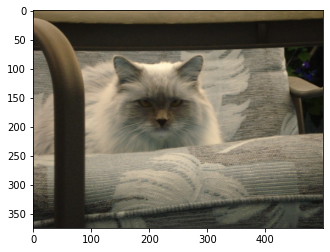

In [57]:
weights_path = '/content/gdrive/MyDrive/Dataset/VOC_2007/tiny-yolov1.hdf5'
image_path = '/content/VOC2007/JPEGImages/000099.jpg'

tyv1 = Tiny_Yolov1(weights_path, image_path)
prediction = tyv1.predict()

predict_class = prediction[..., :20]  # 1 * 7 * 7 * 20
predict_trust = prediction[..., 20:22]  # 1 * 7 * 7 * 2
predict_box = prediction[..., 22:]  # 1 * 7 * 7 * 8

predict_class = np.reshape(predict_class, [7, 7, 1, 20])
predict_trust = np.reshape(predict_trust, [7, 7, 2, 1])
predict_box = np.reshape(predict_box, [7, 7, 2, 4])

predict_scores = predict_class * predict_trust  # 7 * 7 * 2 * 20    # Score of each class for 2 box

box_classes = np.argmax(predict_scores, axis=-1)  # 7 * 7 * 2       # Which class has max score
box_class_scores = np.max(predict_scores, axis=-1)  # 7 * 7 * 2     # Max class score of 2 box
best_box_class_scores = np.max(box_class_scores, axis=-1, keepdims=True)  # 7 * 7 * 1   # Max class score between 2 box

box_mask = box_class_scores >= best_box_class_scores  # ? * 7 * 7 * 2     # True for box has max score, false of another

filter_mask = box_class_scores >= 0.6  # 7 * 7 * 2                  # True for box has score >= 0.6 
filter_mask *= box_mask  # 7 * 7 * 2                                # 1 for box has max score and >= 0.6

filter_mask = np.expand_dims(filter_mask, axis=-1)  # 7 * 7 * 2 * 1

predict_scores *= filter_mask  # 7 * 7 * 2 * 20               # Keep the score of each class for the box has max & >= 0.6, others = 0
predict_box *= filter_mask  # 7 * 7 * 2 * 4                   # Keep the 4 cordinate for the box has max & >= 0.6, others = 0

box_classes = np.expand_dims(box_classes, axis=-1)  # 7 * 7 * 2* 1
box_classes *= filter_mask  # 7 * 7 * 2 * 1                   # Keep the index of class for the box has max & >= 0.6, others = 0

box_xy, box_wh = yolo_head(predict_box)  # 7 * 7 * 2 * 2      # Convert xy_yolo, wh_yolo => xy_center, wh
box_xy_min, box_xy_max = xywh2minmax(box_xy, box_wh)  # 7 * 7 * 2 * 2   # Convert xy_center, xy => xy_min, xy_max

predict_trust *= filter_mask  # 7 * 7 * 2 * 1             # Keep the confident score for the box has max & >= 0.6, others = 0
nms_mask = np.zeros_like(filter_mask)  # 7 * 7 * 2 * 1
predict_trust_max = np.max(predict_trust)  # The max confident score among 7*7*2=48 box
# Apply NMS
max_i = max_j = max_k = 0
while predict_trust_max > 0:
    for i in range(nms_mask.shape[0]):
        for j in range(nms_mask.shape[1]):
            for k in range(nms_mask.shape[2]):
                if predict_trust[i, j, k, 0] == predict_trust_max:
                    nms_mask[i, j, k, 0] = 1
                    filter_mask[i, j, k, 0] = 0
                    max_i = i
                    max_j = j
                    max_k = k
    for i in range(nms_mask.shape[0]):
        for j in range(nms_mask.shape[1]):
            for k in range(nms_mask.shape[2]):
                if filter_mask[i, j, k, 0] == 1:
                    iou_score = iou(box_xy_min[max_i, max_j, max_k, :],
                                    box_xy_max[max_i, max_j, max_k, :],
                                    box_xy_min[i, j, k, :],
                                    box_xy_max[i, j, k, :])
                    if iou_score > 0.2:
                        filter_mask[i, j, k, 0] = 0
    predict_trust *= filter_mask  # 7 * 7 * 2 * 1
    predict_trust_max = np.max(predict_trust)  # 找到置信度最高的框

box_xy_min *= nms_mask
box_xy_max *= nms_mask

image = cv.imread(image_path)
origin_shape = image.shape[0:2]
image = cv.resize(image, (448, 448))
detect_shape = filter_mask.shape

for i in range(detect_shape[0]):
    for j in range(detect_shape[1]):
        for k in range(detect_shape[2]):
            if nms_mask[i, j, k, 0]:
                cv.rectangle(image, (int(box_xy_min[i, j, k, 0]), int(box_xy_min[i, j, k, 1])),
                              (int(box_xy_max[i, j, k, 0]), int(box_xy_max[i, j, k, 1])),
                              (0, 255, 0), 3)
                cv.putText(image, classes_name[box_classes[i, j, k, 0]],
                            (int(box_xy_min[i, j, k, 0]), int(box_xy_min[i, j, k, 1])),
                            1, 1, (0, 0, 255))

image = cv.resize(image, (origin_shape[1], origin_shape[0]))
plt.imshow(image)


In [59]:
weights_path = '/content/gdrive/MyDrive/Dataset/VOC_2007/tiny-yolov1.hdf5'
image_path = '/content/VOC2007/JPEGImages/000099.jpg'

tyv1 = Tiny_Yolov1(weights_path, image_path)
prediction = tyv1.predict()

1/1 [==============================] - 0s 296ms/step


In [60]:
prediction[0][5]

array([[0.05007586, 0.05197552, 0.05054324, 0.04838929, 0.05165926,
        0.04928794, 0.0511195 , 0.04889278, 0.0486918 , 0.05080577,
        0.04921558, 0.04976682, 0.05090296, 0.05098185, 0.05100848,
        0.04921212, 0.04961187, 0.04870566, 0.04912269, 0.05003101,
        0.5011882 , 0.5025042 , 0.5731681 , 0.53594923, 0.5279187 ,
        0.5544207 , 0.5151731 , 0.5311322 , 0.5128997 , 0.53867584],
       [0.04977573, 0.05123361, 0.05103089, 0.04890285, 0.05229782,
        0.04917552, 0.05006884, 0.04902583, 0.04988212, 0.0479132 ,
        0.04932491, 0.05181016, 0.05024967, 0.04968986, 0.05138239,
        0.04974273, 0.0510466 , 0.05018289, 0.04873779, 0.04852664,
        0.49603814, 0.49896538, 0.52552557, 0.53084195, 0.5280113 ,
        0.5374632 , 0.58458954, 0.55127597, 0.5586002 , 0.57385194],
       [0.04832911, 0.05229509, 0.05174725, 0.04888366, 0.05263013,
        0.04991286, 0.04953061, 0.04850201, 0.04872953, 0.05085219,
        0.04971952, 0.05267986, 0.05080458, 0.

In [56]:
a=[[2,3], [4, 5]]
a = np.array(a)
b = a[:, :1]
b*0
a

array([[2, 3],
       [4, 5]])